# Automatic Ticket Classification

## Problem Statement 

You need to build a model that is able to classify customer complaints based on the products/services. By doing so, you can segregate these tickets into their relevant categories and, therefore, help in the quick resolution of the issue.

You will be doing topic modelling on the <b>.json</b> data provided by the company. Since this data is not labelled, you need to apply NMF to analyse patterns and classify tickets into the following five clusters based on their products/services:

* Credit card / Prepaid card

* Bank account services

* Theft/Dispute reporting

* Mortgages/loans

* Others 


With the help of topic modelling, you will be able to map each ticket onto its respective department/category. You can then use this data to train any supervised model such as logistic regression, decision tree or random forest. Using this trained model, you can classify any new customer complaint support ticket into its relevant department.

## Pipelines that needs to be performed:

You need to perform the following eight major tasks to complete the assignment:

1.  Data loading

2. Text preprocessing

3. Exploratory data analysis (EDA)

4. Feature extraction

5. Topic modelling 

6. Model building using supervised learning

7. Model training and evaluation

8. Model inference

## Importing the necessary libraries

In [18]:
# imports for data load
import json 

# imports for data manipulation
import numpy as np
import pandas as pd

# imports for NLP
import re, nltk, spacy, string
import en_core_web_sm
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
nlp = en_core_web_sm.load()

# imports for visualisation
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from plotly.offline import plot
import plotly.graph_objects as go
import plotly.express as px

# imports for model evaluation
from sklearn.metrics import classification_report

# supress warnings to clean the output
import warnings 
warnings.filterwarnings("ignore")



## Loading the data

The data is in JSON format and we need to convert it to a dataframe.

In [3]:
# Opening JSON file 
f = 'Data/complaints-2021-05-14_08_16.json'
file = open(f)
# returns JSON object as  
# a dictionary 
data = json.load(file)
df=pd.json_normalize(data)

## Data preparation

In [4]:
# Inspect the dataframe to understand the given data.
# set the max_columns option to 40
pd.set_option('display.max_columns', 40)
df.head()


,_index,_type,_id,_score,_source.tags,_source.zip_code,_source.complaint_id,_source.issue,_source.date_received,_source.state,_source.consumer_disputed,_source.product,_source.company_response,_source.company,_source.submitted_via,_source.date_sent_to_company,_source.company_public_response,_source.sub_product,_source.timely,_source.complaint_what_happened,_source.sub_issue,_source.consumer_consent_provided
0,complaint-public-v2,complaint,3211475,0.0,None,90301,3211475,Attempts to collect debt not owed,2019-04-13T12:00:00-05:00,CA,N/A,Debt collection,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-13T12:00:00-05:00,None,Credit card debt,Yes,,Debt is not yours,Consent not provided
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,N/A,Debt collection,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,N/A,Credit card or prepaid card,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Problem with rewards from credit card,Consent provided
3,complaint-public-v2,complaint,2673060,0.0,None,48066,2673060,Trouble during payment process,2017-09-13T12:00:00-05:00,MI,N/A,Mortgage,Closed with explanation,JPMORGAN CHASE & CO.,Web,2017-09-14T12:00:00-05:00,None,Conventional home mortgage,Yes,,None,Consent not provided
4,complaint-public-v2,complaint,3203545,0.0,None,10473,3203545,Fees or interest,2019-04-05T12:00:00-05:00,NY,N/A,Credit card or prepaid card,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-04-05T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,,Charged too much interest,N/A


In [5]:
#print the column names
col_names = list(df.columns)
print(col_names)

['_index', '_type', '_id', '_score', '_source.tags', '_source.zip_code', '_source.complaint_id', '_source.issue', '_source.date_received', '_source.state', '_source.consumer_disputed', '_source.product', '_source.company_response', '_source.company', '_source.submitted_via', '_source.date_sent_to_company', '_source.company_public_response', '_source.sub_product', '_source.timely', '_source.complaint_what_happened', '_source.sub_issue', '_source.consumer_consent_provided']


In [6]:
# Assign new column names

# create a list of the new column names
new_col_names = []
for col in col_names:
   replaced =  re.sub('^_','',col)
   replaced =  re.sub('^source.','',replaced)
   new_col_names.append(replaced)

new_col_names[new_col_names.index('complaint_what_happened')] = 'complaints'

# update the dataframe columns using the list 
df.columns = new_col_names

df.head()

,index,type,id,score,tags,zip_code,complaint_id,issue,date_received,state,consumer_disputed,product,company_response,company,submitted_via,date_sent_to_company,company_public_response,sub_product,timely,complaints,sub_issue,consumer_consent_provided
0,complaint-public-v2,complaint,3211475,0.0,None,90301,3211475,Attempts to collect debt not owed,2019-04-13T12:00:00-05:00,CA,N/A,Debt collection,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-13T12:00:00-05:00,None,Credit card debt,Yes,,Debt is not yours,Consent not provided
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,N/A,Debt collection,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,N/A,Credit card or prepaid card,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Problem with rewards from credit card,Consent provided
3,complaint-public-v2,complaint,2673060,0.0,None,48066,2673060,Trouble during payment process,2017-09-13T12:00:00-05:00,MI,N/A,Mortgage,Closed with explanation,JPMORGAN CHASE & CO.,Web,2017-09-14T12:00:00-05:00,None,Conventional home mortgage,Yes,,None,Consent not provided
4,complaint-public-v2,complaint,3203545,0.0,None,10473,3203545,Fees or interest,2019-04-05T12:00:00-05:00,NY,N/A,Credit card or prepaid card,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-04-05T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,,Charged too much interest,N/A


In [7]:
# Assign nan in place of blanks in the complaints column
df['complaints'] = df['complaints'].replace('', pd.NA)
df.head()

,index,type,id,score,tags,zip_code,complaint_id,issue,date_received,state,consumer_disputed,product,company_response,company,submitted_via,date_sent_to_company,company_public_response,sub_product,timely,complaints,sub_issue,consumer_consent_provided
0,complaint-public-v2,complaint,3211475,0.0,None,90301,3211475,Attempts to collect debt not owed,2019-04-13T12:00:00-05:00,CA,N/A,Debt collection,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-13T12:00:00-05:00,None,Credit card debt,Yes,<NA>,Debt is not yours,Consent not provided
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,N/A,Debt collection,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,N/A,Credit card or prepaid card,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Problem with rewards from credit card,Consent provided
3,complaint-public-v2,complaint,2673060,0.0,None,48066,2673060,Trouble during payment process,2017-09-13T12:00:00-05:00,MI,N/A,Mortgage,Closed with explanation,JPMORGAN CHASE & CO.,Web,2017-09-14T12:00:00-05:00,None,Conventional home mortgage,Yes,<NA>,None,Consent not provided
4,complaint-public-v2,complaint,3203545,0.0,None,10473,3203545,Fees or interest,2019-04-05T12:00:00-05:00,NY,N/A,Credit card or prepaid card,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-04-05T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,<NA>,Charged too much interest,N/A


In [8]:
# Remove all rows where complaints column is nan
df = df[~df['complaints'].isna()]
df.head()


,index,type,id,score,tags,zip_code,complaint_id,issue,date_received,state,consumer_disputed,product,company_response,company,submitted_via,date_sent_to_company,company_public_response,sub_product,timely,complaints,sub_issue,consumer_consent_provided
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,N/A,Debt collection,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,N/A,Credit card or prepaid card,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Problem with rewards from credit card,Consent provided
10,complaint-public-v2,complaint,3233499,0.0,None,104XX,3233499,Incorrect information on your report,2019-05-06T12:00:00-05:00,NY,N/A,"Credit reporting, credit repair services, or o...",Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-06T12:00:00-05:00,None,Other personal consumer report,Yes,Chase Card was reported on XX/XX/2019. However...,Information belongs to someone else,Consent provided
11,complaint-public-v2,complaint,3180294,0.0,None,750XX,3180294,Incorrect information on your report,2019-03-14T12:00:00-05:00,TX,N/A,"Credit reporting, credit repair services, or o...",Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-03-15T12:00:00-05:00,None,Credit reporting,Yes,"On XX/XX/2018, while trying to book a XXXX XX...",Information belongs to someone else,Consent provided
14,complaint-public-v2,complaint,3224980,0.0,None,920XX,3224980,Managing an account,2019-04-27T12:00:00-05:00,CA,N/A,Checking or savings account,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-27T12:00:00-05:00,None,Checking account,Yes,my grand son give me check for {$1600.00} i de...,Funds not handled or disbursed as instructed,Consent provided


In [9]:
# reset the index to avoid conflicts or mismatching when joining/merging other dataframes
df.reset_index(inplace=True)
df.head()

,level_0,index,type,id,score,tags,zip_code,complaint_id,issue,date_received,state,consumer_disputed,product,company_response,company,submitted_via,date_sent_to_company,company_public_response,sub_product,timely,complaints,sub_issue,consumer_consent_provided
0,1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,N/A,Debt collection,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided
1,2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,N/A,Credit card or prepaid card,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Problem with rewards from credit card,Consent provided
2,10,complaint-public-v2,complaint,3233499,0.0,None,104XX,3233499,Incorrect information on your report,2019-05-06T12:00:00-05:00,NY,N/A,"Credit reporting, credit repair services, or o...",Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-06T12:00:00-05:00,None,Other personal consumer report,Yes,Chase Card was reported on XX/XX/2019. However...,Information belongs to someone else,Consent provided
3,11,complaint-public-v2,complaint,3180294,0.0,None,750XX,3180294,Incorrect information on your report,2019-03-14T12:00:00-05:00,TX,N/A,"Credit reporting, credit repair services, or o...",Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-03-15T12:00:00-05:00,None,Credit reporting,Yes,"On XX/XX/2018, while trying to book a XXXX XX...",Information belongs to someone else,Consent provided
4,14,complaint-public-v2,complaint,3224980,0.0,None,920XX,3224980,Managing an account,2019-04-27T12:00:00-05:00,CA,N/A,Checking or savings account,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-27T12:00:00-05:00,None,Checking account,Yes,my grand son give me check for {$1600.00} i de...,Funds not handled or disbursed as instructed,Consent provided


## Prepare the text for topic modeling

Once you have removed all the blank complaints, you need to:

* Make the text lowercase
* Remove text in square brackets
* Remove punctuation
* Remove words containing numbers


Once you have done these cleaning operations you need to perform the following:
* Lemmatize the texts
* Extract the POS tags of the lemmatized text and remove all the words which have tags other than NN[tag == "NN"].


In [10]:
# Write your function here to clean the text and remove all the unnecessary elements.
def clean_text(text):
    # convert to lower case
    text = str(text).lower()
    # remove words in square brackets
    text = re.sub(r' +\[.*\] ','',text)
    # remove punctuation
    text = re.sub(r'[' + string.punctuation + ']', '', text)
    # remove words that contain numbers
    text = re.sub(' *\S*\d+\S*', '', text).strip()

    # return the cleaned text
    return text

# Test the function
print(clean_text(' 44 1st This is 44 [great] [great] gre4t gre4t 44s _sample strings!'))

# Apply the function to all rows in the dataframe
df['clean complaints'] = df['complaints'].apply(clean_text)


this is sample strings


In [14]:
# if required download the wordnet resources

#nltk.download()

In [15]:
#Lemmatize the texts using the WordNetLemmatizer
def wordnet_lemmatize_complaint(text):
    lemma_text = ''
    words = word_tokenize(text)
    wnl = WordNetLemmatizer()
    words = [wnl.lemmatize(word = word)for word in words]
    for word in words:
        lemma_text = lemma_text + ' ' + word
    return lemma_text[1:]

# Test the function
print(wordnet_lemmatize_complaint('My mortgage payment was collected early'))


My mortgage payment wa collected early


Using wordnet I don't like the fact that collected was not lemmatized.  I'll try again with spacy

In [16]:
#Lemmatize the texts using the scapy Lemmatizer
def spacy_lemmatize_complaint(text):
    doc = nlp(text)
    return " ".join([token.lemma_ for token in doc])

# Test the function
print(spacy_lemmatize_complaint('My mortgage payment was collected early'))


my mortgage payment be collect early


This is much better proceed with the spacy lemmatizer

In [17]:
# create a new column by applying the lemmatization function
df['lemmatized complaints'] = df['clean complaints'].apply(spacy_lemmatize_complaint)

In [19]:
# check the changes have worked
df.head()

,level_0,index,type,id,score,tags,zip_code,complaint_id,issue,date_received,state,consumer_disputed,product,company_response,company,submitted_via,date_sent_to_company,company_public_response,sub_product,timely,complaints,sub_issue,consumer_consent_provided,clean complaints,lemmatized complaints
0,1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,N/A,Debt collection,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided,good morning my name is xxxx xxxx and i apprec...,good morning my name be xxxx xxxx and I apprec...
1,2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,N/A,Credit card or prepaid card,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Problem with rewards from credit card,Consent provided,i upgraded my xxxx xxxx card in and was told b...,I upgrade my xxxx xxxx card in and be tell by ...
2,10,complaint-public-v2,complaint,3233499,0.0,None,104XX,3233499,Incorrect information on your report,2019-05-06T12:00:00-05:00,NY,N/A,"Credit reporting, credit repair services, or o...",Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-06T12:00:00-05:00,None,Other personal consumer report,Yes,Chase Card was reported on XX/XX/2019. However...,Information belongs to someone else,Consent provided,chase card was reported on however fraudulent ...,chase card be report on however fraudulent app...
3,11,complaint-public-v2,complaint,3180294,0.0,None,750XX,3180294,Incorrect information on your report,2019-03-14T12:00:00-05:00,TX,N/A,"Credit reporting, credit repair services, or o...",Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-03-15T12:00:00-05:00,None,Credit reporting,Yes,"On XX/XX/2018, while trying to book a XXXX XX...",Information belongs to someone else,Consent provided,on while trying to book a xxxx xxxx ticket i...,on while try to book a xxxx xxxx ticket I ...
4,14,complaint-public-v2,complaint,3224980,0.0,None,920XX,3224980,Managing an account,2019-04-27T12:00:00-05:00,CA,N/A,Checking or savings account,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-27T12:00:00-05:00,None,Checking account,Yes,my grand son give me check for {$1600.00} i de...,Funds not handled or disbursed as instructed,Consent provided,my grand son give me check for i deposit it in...,my grand son give I check for I deposit it int...


In [20]:
#Create a dataframe('df_clean') that will have only the complaints and the lemmatized complaints 
df_clean = df.filter(['complaints','lemmatized complaints'])

In [21]:
# check the changes have worked
df_clean

,complaints,lemmatized complaints
0,Good morning my name is XXXX XXXX and I apprec...,good morning my name be xxxx xxxx and I apprec...
1,I upgraded my XXXX XXXX card in XX/XX/2018 and...,I upgrade my xxxx xxxx card in and be tell by ...
2,Chase Card was reported on XX/XX/2019. However...,chase card be report on however fraudulent app...
3,"On XX/XX/2018, while trying to book a XXXX XX...",on while try to book a xxxx xxxx ticket I ...
4,my grand son give me check for {$1600.00} i de...,my grand son give I check for I deposit it int...
...,...,...
21067,After being a Chase Card customer for well ove...,after be a chase card customer for well over a...
21068,"On Wednesday, XX/XX/XXXX I called Chas, my XXX...",on wednesday xxxxxxxx I call chas my xxxx xxxx...
21069,I am not familiar with XXXX pay and did not un...,I be not familiar with xxxx pay and do not und...
21070,I have had flawless credit for 30 yrs. I've ha...,I have have flawless credit for yrs I ve have ...


In [22]:
#Write a function to extract the POS tags 
def pos_tag(text):
    NN_text = ''
    tokenized_sentence = nlp(text)
    for word in tokenized_sentence:
        if word.tag_ == 'NN':
          NN_text = NN_text + ' ' + word.text
    return NN_text[1:]

# create a new column by applying the function to remove everything except nouns
df_clean["complaint_POS_removed"] =  df_clean['lemmatized complaints'].apply(pos_tag)


In [23]:
#The clean dataframe should now contain the raw complaint, lemmatized complaint and the complaint after removing POS tags.
df_clean

,complaints,lemmatized complaints,complaint_POS_removed
0,Good morning my name is XXXX XXXX and I apprec...,good morning my name be xxxx xxxx and I apprec...,morning name stop bank service ask debt verifi...
1,I upgraded my XXXX XXXX card in XX/XX/2018 and...,I upgrade my xxxx xxxx card in and be tell by ...,xxxx agent anniversary date agent information ...
2,Chase Card was reported on XX/XX/2019. However...,chase card be report on however fraudulent app...,chase card report application identity consent...
3,"On XX/XX/2018, while trying to book a XXXX XX...",on while try to book a xxxx xxxx ticket I ...,xxxx xxxx ticket offer ticket reward card info...
4,my grand son give me check for {$1600.00} i de...,my grand son give I check for I deposit it int...,son chase account fund chase bank account mone...
...,...,...,...
21067,After being a Chase Card customer for well ove...,after be a chase card customer for well over a...,chase card customer decade solicitation credit...
21068,"On Wednesday, XX/XX/XXXX I called Chas, my XXX...",on wednesday xxxxxxxx I call chas my xxxx xxxx...,xxxx credit card provider claim purchase prote...
21069,I am not familiar with XXXX pay and did not un...,I be not familiar with xxxx pay and do not und...,xxxx risk consumer chase bank app chase year b...
21070,I have had flawless credit for 30 yrs. I've ha...,I have have flawless credit for yrs I ve have ...,credit yrs chase credit card chase freedom pro...


## Exploratory data analysis to get familiar with the data.

Write the code in this task to perform the following:

*   Visualise the data according to the 'Complaint' character length
*   Using a word cloud find the top 40 words by frequency among all the articles after processing the text
*   Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text. ‘




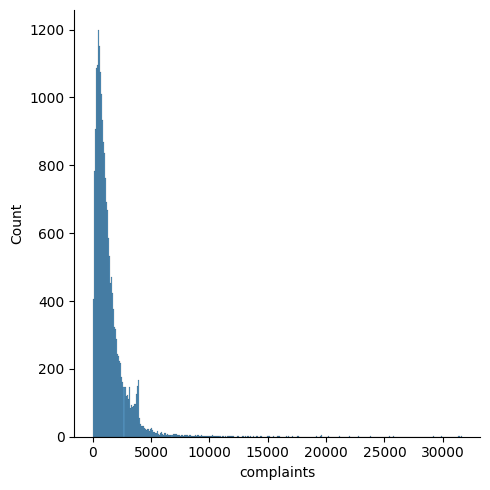

In [24]:
# visualise the data according to the 'Complaint' character length
df_len = df_clean['complaints'].apply(len)
from matplotlib import rcParams
sns.displot(df_len)



<Axes: >

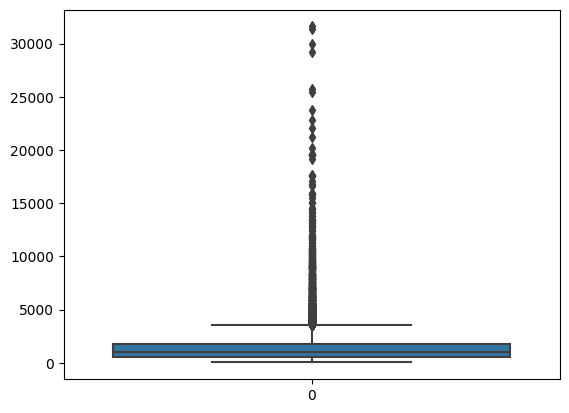

In [25]:
# lets look at it as a box plot
sns.boxplot(df_len)

#### Find the top 40 words by frequency among all the articles after processing the text.

In [26]:
# install wordcloud if not already installed
%pip install wordcloud

Note: you may need to restart the kernel to use updated packages.


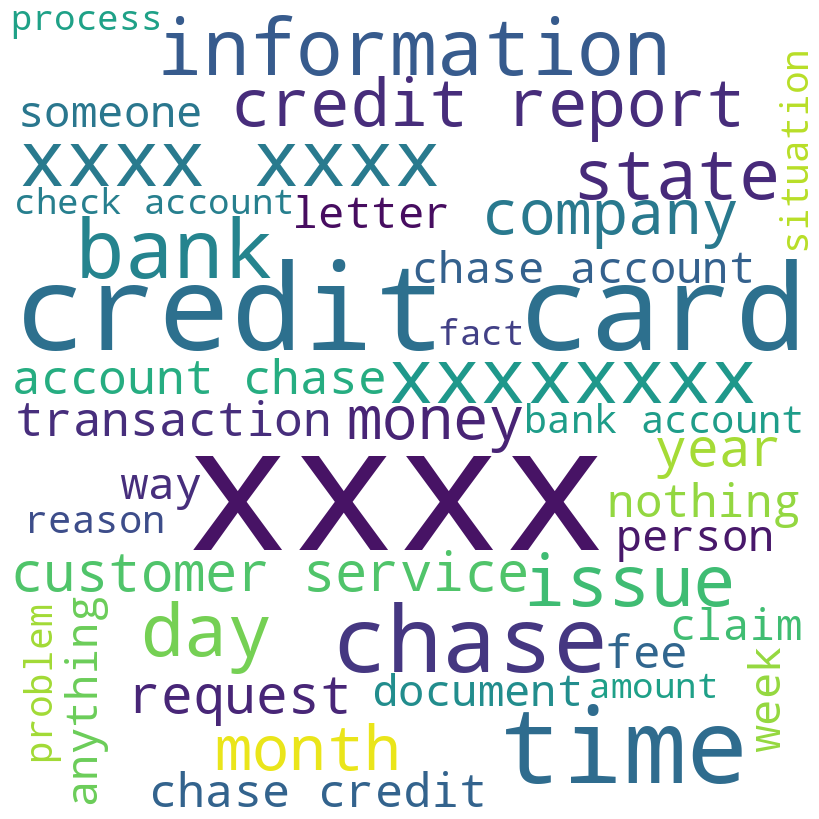

In [27]:
#Using a word cloud find the top 40 words by frequency among all the articles after processing the text
from wordcloud import WordCloud,STOPWORDS
all_words = ''
stopwords = set(STOPWORDS)
for row in df_clean['complaint_POS_removed']:
    tokens = row.split()
    all_words += " ".join(tokens)+" "

wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stopwords,
                max_words=40,
                min_font_size = 10).generate(all_words)
 
# plot the WordCloud image                      
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
 
plt.show()

In [28]:
#Removing -PRON- from the text corpus
df_clean['Complaint_clean'] = df_clean['complaint_POS_removed'].str.replace('-PRON-', '')

#### Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text.

In [29]:
# a function to find the top n-grams in a series
from typing import List
from nltk.util import ngrams
def extract_top_ngrams(series, n, top=30):
    
    # Tokenize the series
    tokens = series.apply(word_tokenize)
    
    # Generate n-grams
    n_grams = tokens.apply(lambda x: list(ngrams(x, n)))
    
    # Flatten the list of n-grams
    flat_n_grams = [item for sublist in n_grams for item in sublist]

    # Convert tuples to strings
    str_n_grams = [' '.join(gram) for gram in flat_n_grams]

    return pd.DataFrame(str_n_grams,columns=['tokens']).value_counts()[:top]



In [30]:
#extract_top_ngrams(df_clean['complaint_POS_removed'],1,10)
top_30_unigrams = extract_top_ngrams(df_clean['Complaint_clean'],1,30)

In [31]:
#Print the top 10 words in the unigram frequency
top_30_unigrams.head(10)

tokens  
chase       52497
xxxx        47944
account     46690
credit      33447
card        30190
bank        21441
payment     21132
time        15977
charge      14099
xxxxxxxx    13193
Name: count, dtype: int64

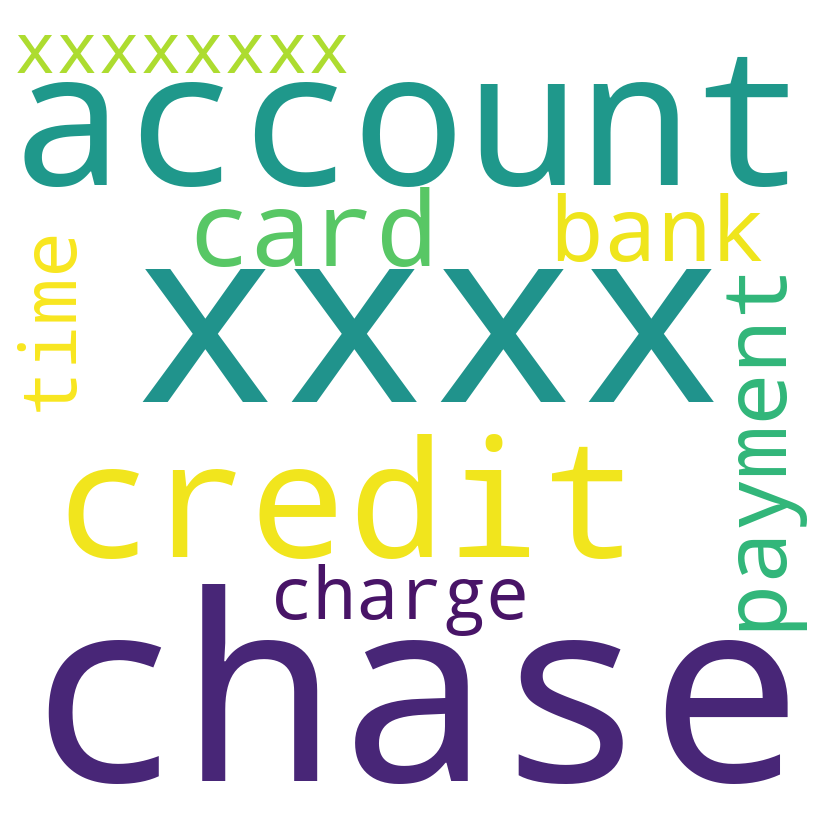

In [32]:
# a function to display a wordcloud
def disp_top_x_wordcloud(series,x):

    freq_dict = {}
    for row in range(x):
        freq_dict[str(series.index[row])[2:-3]] =  series[row]
    wordcloud.generate_from_frequencies(freq_dict)
    plt.figure(figsize = (8, 8), facecolor = None)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.tight_layout(pad = 0)
    plt.show()

# Show the top 10 unigrams
disp_top_x_wordcloud(top_30_unigrams,10)

In [33]:
# get the top 30 bigrams
top_30_bigrams = extract_top_ngrams(df_clean['Complaint_clean'],2,30)


In [34]:
#Print the top 10 words in the bigram frequency
top_30_bigrams.head(10)

tokens          
credit card         12834
xxxx xxxx            4993
credit report        3925
customer service     3057
account chase        2787
chase credit         2767
chase account        2509
bank account         2377
check account        2232
account account      2064
Name: count, dtype: int64

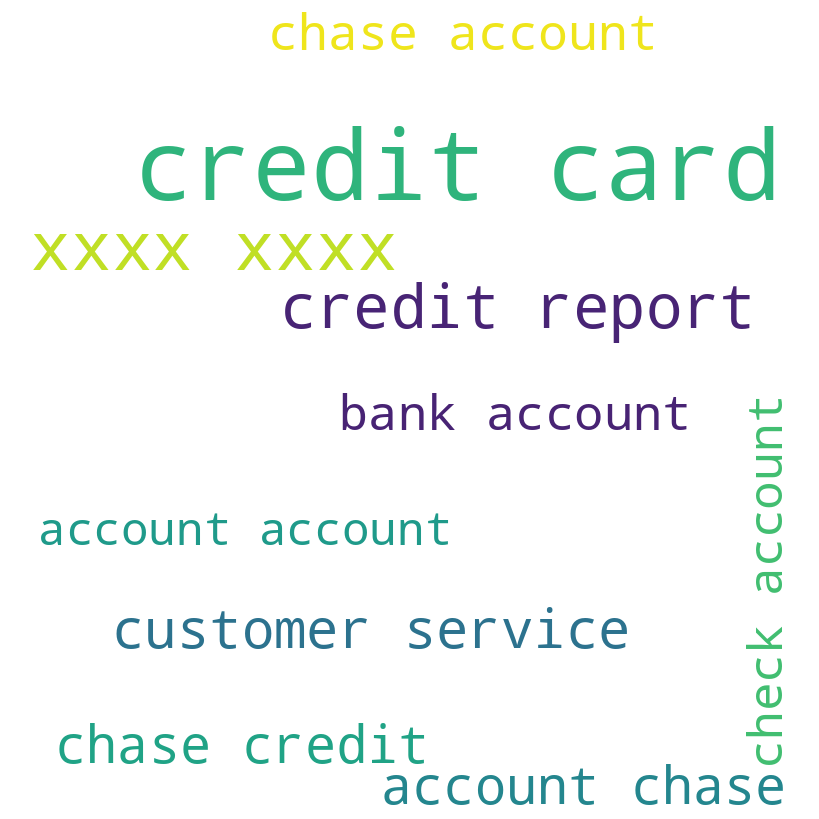

In [35]:
# Show the top 10 bigrams in a wordcloud
disp_top_x_wordcloud(top_30_bigrams,10)

In [36]:
#Write your code here to find the top 30 trigram frequency among the complaints in the cleaned datafram(df_clean). 
top_30_trigrams = extract_top_ngrams(df_clean['Complaint_clean'],3,30)


In [37]:
#Print the top 10 words in the trigram frequency
top_30_trigrams.head(10)

tokens               
chase credit card        1874
credit card account      1066
credit card company       984
xxxx credit card          780
xxxx xxxx xxxx            726
credit card chase         677
inquiry credit report     489
credit card credit        480
credit card xxxx          395
account credit card       395
Name: count, dtype: int64

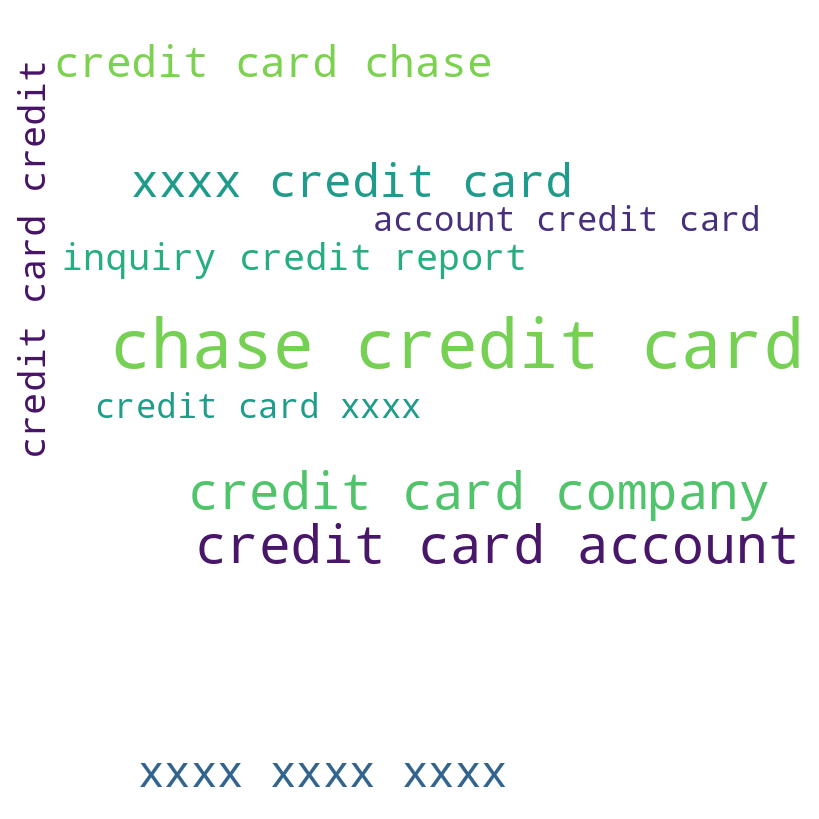

In [38]:
# Show the top 10 bigrams in a wordcloud
disp_top_x_wordcloud(top_30_trigrams,10)

## The personal details of customer has been masked in the dataset with xxxx. Let's remove the masked text as this will be of no use for our analysis

In [39]:
df_clean['Complaint_clean'] = df_clean['Complaint_clean'].str.replace('xxxx','')

In [40]:
#All masked texts has been removed
df_clean

,complaints,lemmatized complaints,complaint_POS_removed,Complaint_clean
0,Good morning my name is XXXX XXXX and I apprec...,good morning my name be xxxx xxxx and I apprec...,morning name stop bank service ask debt verifi...,morning name stop bank service ask debt verifi...
1,I upgraded my XXXX XXXX card in XX/XX/2018 and...,I upgrade my xxxx xxxx card in and be tell by ...,xxxx agent anniversary date agent information ...,agent anniversary date agent information orde...
2,Chase Card was reported on XX/XX/2019. However...,chase card be report on however fraudulent app...,chase card report application identity consent...,chase card report application identity consent...
3,"On XX/XX/2018, while trying to book a XXXX XX...",on while try to book a xxxx xxxx ticket I ...,xxxx xxxx ticket offer ticket reward card info...,ticket offer ticket reward card information ...
4,my grand son give me check for {$1600.00} i de...,my grand son give I check for I deposit it int...,son chase account fund chase bank account mone...,son chase account fund chase bank account mone...
...,...,...,...,...
21067,After being a Chase Card customer for well ove...,after be a chase card customer for well over a...,chase card customer decade solicitation credit...,chase card customer decade solicitation credit...
21068,"On Wednesday, XX/XX/XXXX I called Chas, my XXX...",on wednesday xxxxxxxx I call chas my xxxx xxxx...,xxxx credit card provider claim purchase prote...,credit card provider claim purchase protectio...
21069,I am not familiar with XXXX pay and did not un...,I be not familiar with xxxx pay and do not und...,xxxx risk consumer chase bank app chase year b...,risk consumer chase bank app chase year banki...
21070,I have had flawless credit for 30 yrs. I've ha...,I have have flawless credit for yrs I ve have ...,credit yrs chase credit card chase freedom pro...,credit yrs chase credit card chase freedom pro...


## Feature Extraction
Convert the raw texts to a matrix of TF-IDF features

**max_df** is used for removing terms that appear too frequently, also known as "corpus-specific stop words"
max_df = 0.95 means "ignore terms that appear in more than 95% of the complaints"

**min_df** is used for removing terms that appear too infrequently
min_df = 2 means "ignore terms that appear in less than 2 complaints"

In [52]:
#Write your code here to initialise the TfidfVectorizer 

import pandas as pd
from sklearn.feature_extraction.text import  TfidfVectorizer

#define tf-idf
tf_idf_vec = TfidfVectorizer(
                        max_df=0.95,
                        min_df=0.01,
                        ngram_range=(1,1),stop_words='english')
 


#### Create a document term matrix using fit_transform

The contents of a document term matrix are tuples of (complaint_id,token_id) tf-idf score:
The tuples that are not there have a tf-idf score of 0

In [53]:
#Write your code here to create the Document Term Matrix by transforming the complaints column present in df_clean.
#transform
tf_idf_data = tf_idf_vec.fit_transform(df_clean['Complaint_clean'])
print(tf_idf_data.shape)

#create dataframe
tf_idf_dataframe=pd.DataFrame(tf_idf_data.toarray(),columns=tf_idf_vec.get_feature_names_out())
print(tf_idf_dataframe)
print("\n")

(21072, 459)
       ability  access  accord   account  acct  ach  act    action  activity  \
0          0.0     0.0     0.0  0.083095   0.0  0.0  0.0  0.000000       0.0   
1          0.0     0.0     0.0  0.095381   0.0  0.0  0.0  0.000000       0.0   
2          0.0     0.0     0.0  0.000000   0.0  0.0  0.0  0.000000       0.0   
3          0.0     0.0     0.0  0.133300   0.0  0.0  0.0  0.000000       0.0   
4          0.0     0.0     0.0  0.130528   0.0  0.0  0.0  0.000000       0.0   
...        ...     ...     ...       ...   ...  ...  ...       ...       ...   
21067      0.0     0.0     0.0  0.059903   0.0  0.0  0.0  0.000000       0.0   
21068      0.0     0.0     0.0  0.000000   0.0  0.0  0.0  0.000000       0.0   
21069      0.0     0.0     0.0  0.028455   0.0  0.0  0.0  0.069081       0.0   
21070      0.0     0.0     0.0  0.000000   0.0  0.0  0.0  0.000000       0.0   
21071      0.0     0.0     0.0  0.222524   0.0  0.0  0.0  0.000000       0.0   

       addition  address  

## Topic Modelling using NMF

Non-Negative Matrix Factorization (NMF) is an unsupervised technique so there are no labeling of topics that the model will be trained on. The way it works is that, NMF decomposes (or factorizes) high-dimensional vectors into a lower-dimensional representation. These lower-dimensional vectors are non-negative which also means their coefficients are non-negative.

In this task you have to perform the following:

* Find the best number of clusters 
* Apply the best number to create word clusters
* Inspect & validate the correction of each cluster wrt the complaints 
* Correct the labels if needed 
* Map the clusters to topics/cluster names

In [49]:
from sklearn.decomposition import NMF

## Manual Topic Modeling
You need to do take the trial & error approach to find the best num of topics for your NMF model.

The only parameter that is required is the number of components i.e. the number of topics we want. This is the most crucial step in the whole topic modeling process and will greatly affect how good your final topics are.

As we have 5 categories, lets start with 5 topics and see if they match

In [54]:
# Load nmf_model with 5 components
num_topics = 5 #write the value you want to test out

#keep the random_state =40
nmf_model = NMF(random_state=40,n_components=num_topics)

In [55]:
W = nmf_model.fit_transform(tf_idf_dataframe)  # Document-topic matrix
H = nmf_model.components_       # Topic-term matrix

In [56]:
#Print the Top15 words for each of the topics
words = np.array(tf_idf_vec.get_feature_names_out())
topic_words = pd.DataFrame(np.zeros((num_topics, 15)), index=[f'Topic {i + 1}' for i in range(num_topics)],
                           columns=[f'Word {i + 1}' for i in range(15)]).astype(str)
for i in range(num_topics):
    ix = H[i].argsort()[::-1][:15]
    topic_words.iloc[i] = words[ix]

topic_words

,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14,Word 15
Topic 1,credit,card,report,inquiry,chase,account,score,company,debt,limit,information,application,year,balance,letter
Topic 2,account,check,bank,money,fund,chase,deposit,branch,day,checking,number,business,transaction,transfer,customer
Topic 3,loan,mortgage,home,chase,modification,property,year,document,letter,rate,foreclosure,time,house,sale,request
Topic 4,charge,card,chase,dispute,transaction,fee,merchant,fraud,claim,purchase,service,email,time,refund,company
Topic 5,payment,balance,month,fee,statement,day,time,chase,date,auto,pay,credit,mortgage,year,car


Looking at the topics they could be aligned to the categories we are looking for:

|Topic|Category                        |
|-----|--------------------------------|
|  1  | Credit card or prepaid card    |
|  2  | Bank Account services          |
|  3  | Mortgage/Loan                  |
|  4  | Theft/Dispute Reporting        |
|  5  | Other                          |

I'll check to see if this works when assigning topics to tickets

In [57]:
#Create the best topic for each complaint in terms of integer value 0,1,2,3 & 4
W = pd.DataFrame(W, columns=[f'Topic {i + 1}' for i in range(num_topics)])
W['max_topic'] = W.apply(lambda x: x.idxmax(), axis=1)
W[pd.notnull(W['max_topic'])].head(10)

,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,max_topic
0,0.007913,0.030600,0.017463,0.007672,0.007788,Topic 2
1,0.002183,0.016342,0.007088,0.007194,0.003041,Topic 2
2,0.046930,0.000000,0.003271,0.005237,0.000000,Topic 1
3,0.044124,0.024496,0.014320,0.003011,0.000455,Topic 1
4,0.000000,0.094142,0.009811,0.012167,0.000000,Topic 2
5,0.027946,0.000000,0.000000,0.000000,0.000000,Topic 1
6,0.000898,0.090824,0.006802,0.008132,0.014604,Topic 2
7,0.002401,0.005604,0.047022,0.009464,0.062299,Topic 5
8,0.000000,0.033082,0.017626,0.070086,0.003501,Topic 4
9,0.105810,0.000000,0.000000,0.000000,0.000000,Topic 1


In [58]:
W.shape

(21072, 6)

In [59]:
W.max_topic.value_counts()

max_topic
Topic 2    6459
Topic 4    5269
Topic 3    3547
Topic 1    3522
Topic 5    2275
Name: count, dtype: int64

In [60]:
#Create a backup of df_clean so we can try other numbers of topics if we need to
df_clean_backup = df_clean.copy()


In [61]:
#Assign the best topic to each of the cmplaints in Topic Column

df_clean['Topic'] = W['max_topic']

In [62]:
# look at the distribution
df_clean['Topic'].value_counts()

Topic
Topic 2    6459
Topic 4    5269
Topic 3    3547
Topic 1    3522
Topic 5    2275
Name: count, dtype: int64

In [63]:
#Print the first 5 Complaint for each of the Topics
df_clean=df_clean.groupby('Topic').head(5)
pd.options.display.max_colwidth = 60
print(df_clean.sort_values('Topic').filter(['complaints','Topic']))


                                                     complaints    Topic
2   Chase Card was reported on XX/XX/2019. However, fraudule...  Topic 1
3   On XX/XX/2018, while trying to book a XXXX  XXXX  ticket...  Topic 1
5                                 Can you please remove inquiry  Topic 1
9   I have a Chase credit card which is incorrectly reportin...  Topic 1
11  I have reached out to XXXX several times in attempt to h...  Topic 1
0   Good morning my name is XXXX XXXX and I appreciate it if...  Topic 2
1   I upgraded my XXXX XXXX card in XX/XX/2018 and was told ...  Topic 2
4   my grand son give me check for {$1600.00} i deposit it i...  Topic 2
6   With out notice J.P. Morgan Chase restricted my account ...  Topic 2
10          mishandling of this account by Chase auto and XXXX.  Topic 2
47  I am XXXX military member ( XXXX ) with the XXXX. Chase ...  Topic 3
41  My name is XXXX XXXX. I have missed a payment in XX/XX/2...  Topic 3
32  I bought a new XXXX XXXX on XX/XX/XXXX from XXX

In [64]:
#this is difficult to read so I'll save it to a spreadsheet
import os
os.makedirs('temp_extracts', exist_ok=True)  
df_clean.sort_values('Topic').filter(['complaints','Topic']).to_csv('temp_extracts/5_topics.csv',sep='|')

Having looked at the topics asigned and manually categorising the sample, the automatically assigned topics only matched my manual classification 56% of the time.  I'll increase the number of topics and see if this improves the coherence of the topics and the categories

In [65]:
# restore df_clean from the backup
df_clean = df_clean_backup.copy()

In [66]:
# write a function to repeat the process above for different numbers of topics
def generate_nmf_topics(df,tf_idf_df, num_topics):

    #keep the random_state =40
    nmf_model = NMF(random_state=40,n_components=num_topics)

    W = nmf_model.fit_transform(tf_idf_df)  # Document-topic matrix
    H = nmf_model.components_       # Topic-term matrix

    #Print the Top15 words for each of the topics
    words = np.array(tf_idf_vec.get_feature_names_out())
    topic_words = pd.DataFrame(np.zeros((num_topics, 15)), index=[f'Topic {i + 1}' for i in range(num_topics)],
                           columns=[f'Word {i + 1}' for i in range(15)]).astype(str)
    for i in range(num_topics):
        ix = H[i].argsort()[::-1][:15]
        topic_words.iloc[i] = words[ix]

    print(topic_words)

    #Create the best topic for each complaint in terms of integer value 0,1,2,3 & 4
    W = pd.DataFrame(W, columns=[f'Topic {i + 1}' for i in range(num_topics)])
    W['max_topic'] = W.apply(lambda x: x.idxmax(), axis=1)
    
    df['Topic'] = W['max_topic']
    
    #Print the first 5 Complaint for each of the Topics
    df_topic_head=df.groupby('Topic').head(5)

    df_topic_head.sort_values('Topic').filter(['complaints','Topic']).to_csv('temp_extracts/' + str(num_topics) + '_topics.csv',sep='|')
    
    return df

In [67]:
generate_nmf_topics(df_clean,tf_idf_dataframe, 10)

           Word 1     Word 2       Word 3         Word 4        Word 5  \
Topic 1    report     credit         debt    information     reporting   
Topic 2   account      chase     checking         reason        branch   
Topic 3      loan   mortgage         home          chase  modification   
Topic 4    charge    dispute        chase       merchant         fraud   
Topic 5   payment      month      balance      statement           day   
Topic 6      card     credit        chase          point      purchase   
Topic 7   inquiry     credit  application  authorization        report   
Topic 8       fee  overdraft      balance         charge          year   
Topic 9      bank      money  transaction          claim        number   
Topic 10    check    deposit         fund           bank          cash   

                Word 6    Word 7       Word 8       Word 9    Word 10  \
Topic 1        company     score     identity        theft     agency   
Topic 2        balance   deposit     bu

,complaints,lemmatized complaints,complaint_POS_removed,Complaint_clean,Topic
0,Good morning my name is XXXX XXXX and I appreciate it if...,good morning my name be xxxx xxxx and I appreciate it if...,morning name stop bank service ask debt verification sta...,morning name stop bank service ask debt verification sta...,Topic 9
1,I upgraded my XXXX XXXX card in XX/XX/2018 and was told ...,I upgrade my xxxx xxxx card in and be tell by the agent ...,xxxx agent anniversary date agent information order acco...,agent anniversary date agent information order account ...,Topic 2
2,"Chase Card was reported on XX/XX/2019. However, fraudule...",chase card be report on however fraudulent application h...,chase card report application identity consent service c...,chase card report application identity consent service c...,Topic 1
3,"On XX/XX/2018, while trying to book a XXXX XXXX ticket...",on while try to book a xxxx xxxx ticket I come acros...,xxxx xxxx ticket offer ticket reward card information of...,ticket offer ticket reward card information offer minu...,Topic 1
4,my grand son give me check for {$1600.00} i deposit it i...,my grand son give I check for I deposit it into my chase...,son chase account fund chase bank account money son chec...,son chase account fund chase bank account money son chec...,Topic 10
...,...,...,...,...,...
21067,After being a Chase Card customer for well over a decade...,after be a chase card customer for well over a decade be...,chase card customer decade solicitation credit card chas...,chase card customer decade solicitation credit card chas...,Topic 6
21068,"On Wednesday, XX/XX/XXXX I called Chas, my XXXX XXXX Vis...",on wednesday xxxxxxxx I call chas my xxxx xxxx visa cred...,xxxx credit card provider claim purchase protection bene...,credit card provider claim purchase protection benefit ...,Topic 9
21069,I am not familiar with XXXX pay and did not understand t...,I be not familiar with xxxx pay and do not understand th...,xxxx risk consumer chase bank app chase year banking mer...,risk consumer chase bank app chase year banking merchan...,Topic 4
21070,I have had flawless credit for 30 yrs. I've had Chase cr...,I have have flawless credit for yrs I ve have chase cred...,credit yrs chase credit card chase freedom problem balan...,credit yrs chase credit card chase freedom problem balan...,Topic 5


Looking at the topics they could be aligned to the categories we are looking for:

|Topic|Category                        |
|-----|--------------------------------|
|  1  | Other                          |
|  2  | Bank Account services          |
|  3  | Mortgage/Loan                  |
|  4  | Theft/Dispute Reporting        |
|  5  | Mortgage/Loan                  |
|  6  | Credit card or prepaid card    |
|  7  | Other                          |
|  8  | Bank Account services          |
|  9  | Theft/Dispute Reporting        |
| 10  | Bank Account services          |

I checked to see if this works when assigning topics to tickets.  In this instance the topics matched my manual classification 66% of the time this is 10 percentage points better than the previous topics.  I'll try once more with 15 topics to see if it improves further.

In [68]:
generate_nmf_topics(df_clean,tf_idf_dataframe, 15)

               Word 1        Word 2       Word 3         Word 4        Word 5  \
Topic 1       account      checking        chase         reason       deposit   
Topic 2         check       deposit         fund           cash           day   
Topic 3          loan  modification         rate           home       student   
Topic 4        charge       dispute     merchant        company         fraud   
Topic 5       payment         month          day      statement          time   
Topic 6          card        credit        chase           year         score   
Topic 7        report        credit         debt      reporting       company   
Topic 8           fee     overdraft         year           time      customer   
Topic 9   transaction         claim        fraud          debit        police   
Topic 10         bank          fund     customer      complaint        number   
Topic 11        chase        letter  information         number       dispute   
Topic 12      balance      t

,complaints,lemmatized complaints,complaint_POS_removed,Complaint_clean,Topic
0,Good morning my name is XXXX XXXX and I appreciate it if...,good morning my name be xxxx xxxx and I appreciate it if...,morning name stop bank service ask debt verification sta...,morning name stop bank service ask debt verification sta...,Topic 10
1,I upgraded my XXXX XXXX card in XX/XX/2018 and was told ...,I upgrade my xxxx xxxx card in and be tell by the agent ...,xxxx agent anniversary date agent information order acco...,agent anniversary date agent information order account ...,Topic 11
2,"Chase Card was reported on XX/XX/2019. However, fraudule...",chase card be report on however fraudulent application h...,chase card report application identity consent service c...,chase card report application identity consent service c...,Topic 7
3,"On XX/XX/2018, while trying to book a XXXX XXXX ticket...",on while try to book a xxxx xxxx ticket I come acros...,xxxx xxxx ticket offer ticket reward card information of...,ticket offer ticket reward card information offer minu...,Topic 11
4,my grand son give me check for {$1600.00} i deposit it i...,my grand son give I check for I deposit it into my chase...,son chase account fund chase bank account money son chec...,son chase account fund chase bank account money son chec...,Topic 15
...,...,...,...,...,...
21067,After being a Chase Card customer for well over a decade...,after be a chase card customer for well over a decade be...,chase card customer decade solicitation credit card chas...,chase card customer decade solicitation credit card chas...,Topic 6
21068,"On Wednesday, XX/XX/XXXX I called Chas, my XXXX XXXX Vis...",on wednesday xxxxxxxx I call chas my xxxx xxxx visa cred...,xxxx credit card provider claim purchase protection bene...,credit card provider claim purchase protection benefit ...,Topic 9
21069,I am not familiar with XXXX pay and did not understand t...,I be not familiar with xxxx pay and do not understand th...,xxxx risk consumer chase bank app chase year banking mer...,risk consumer chase bank app chase year banking merchan...,Topic 11
21070,I have had flawless credit for 30 yrs. I've had Chase cr...,I have have flawless credit for yrs I ve have chase cred...,credit yrs chase credit card chase freedom problem balan...,credit yrs chase credit card chase freedom problem balan...,Topic 12


Looking at the topics they could be aligned to the categories we are looking for:

|Topic|Category                        |
|-----|--------------------------------|
|  1  | Bank Account services          |
|  2  | Bank Account services          |
|  3  | Mortgage/Loan                  |
|  4  | Theft/Dispute Reporting        |
|  5  | Mortgage/Loan                  |
|  6  | Credit card or prepaid card    |
|  7  | Other                          |
|  8  | Bank Account services          |
|  9  | Theft/Dispute Reporting        |
| 10  | Bank Account services          |
| 11  | Other                          |
| 12  | Credit card or prepaid card    |
| 13  | Other                          |
| 14  | Mortgage/Loan                  |
| 15  | Bank Account services          |

I checked to see if this works when assigning topics to tickets.  In this instance the topics matched my manual classification 76% of the time this is another 10 percentage points better.

I've decided I'll proceed with the 15 topics

#### After evaluating the mapping, if the topics assigned are correct then assign these names to the relevant topic:
* Bank Account services
* Credit card or prepaid card
* Theft/Dispute Reporting
* Mortgage/Loan
* Others

In [69]:
# generate the dataframe with the topics column added
df_clean = generate_nmf_topics(df_clean,tf_idf_dataframe, 15)

               Word 1        Word 2       Word 3         Word 4        Word 5  \
Topic 1       account      checking        chase         reason       deposit   
Topic 2         check       deposit         fund           cash           day   
Topic 3          loan  modification         rate           home       student   
Topic 4        charge       dispute     merchant        company         fraud   
Topic 5       payment         month          day      statement          time   
Topic 6          card        credit        chase           year         score   
Topic 7        report        credit         debt      reporting       company   
Topic 8           fee     overdraft         year           time      customer   
Topic 9   transaction         claim        fraud          debit        police   
Topic 10         bank          fund     customer      complaint        number   
Topic 11        chase        letter  information         number       dispute   
Topic 12      balance      t

In [70]:
# check the results
df_clean.shape

(21072, 5)

In [71]:
# check the distribution
df_clean['Topic'].value_counts()

Topic
Topic 11    3893
Topic 6     2071
Topic 14    1772
Topic 5     1650
Topic 15    1460
Topic 2     1449
Topic 4     1418
Topic 3     1217
Topic 10    1198
Topic 7     1102
Topic 9      946
Topic 8      862
Topic 12     860
Topic 13     705
Topic 1      469
Name: count, dtype: int64

In [72]:
#Create the dictionary of Topic names and Topics

Topic_names = {     
    'Topic 1': 'Bank account services',
    'Topic 2': 'Bank account services',
    'Topic 3': 'Mortgages/loans',
    'Topic 4': 'Theft/Dispute reporting',
    'Topic 5': 'Mortgages/loans',
    'Topic 6': 'Credit card / Prepaid card',
    'Topic 7': 'Other',
    'Topic 8': 'Bank account services',
    'Topic 9': 'Theft/Dispute reporting',
    'Topic 10':'Bank account services',
    'Topic 11':'Other',
    'Topic 12':'Credit card / Prepaid card',
    'Topic 13':'Other',
    'Topic 14':'Mortgages/loans',
    'Topic 15':'Bank account services'
        }
#Replace Topics with Topic Names
df_clean['Topic'] = df_clean['Topic'].map(Topic_names)

In [73]:
# Check the results
df_clean

,complaints,lemmatized complaints,complaint_POS_removed,Complaint_clean,Topic
0,Good morning my name is XXXX XXXX and I appreciate it if...,good morning my name be xxxx xxxx and I appreciate it if...,morning name stop bank service ask debt verification sta...,morning name stop bank service ask debt verification sta...,Bank account services
1,I upgraded my XXXX XXXX card in XX/XX/2018 and was told ...,I upgrade my xxxx xxxx card in and be tell by the agent ...,xxxx agent anniversary date agent information order acco...,agent anniversary date agent information order account ...,Other
2,"Chase Card was reported on XX/XX/2019. However, fraudule...",chase card be report on however fraudulent application h...,chase card report application identity consent service c...,chase card report application identity consent service c...,Other
3,"On XX/XX/2018, while trying to book a XXXX XXXX ticket...",on while try to book a xxxx xxxx ticket I come acros...,xxxx xxxx ticket offer ticket reward card information of...,ticket offer ticket reward card information offer minu...,Other
4,my grand son give me check for {$1600.00} i deposit it i...,my grand son give I check for I deposit it into my chase...,son chase account fund chase bank account money son chec...,son chase account fund chase bank account money son chec...,Bank account services
...,...,...,...,...,...
21067,After being a Chase Card customer for well over a decade...,after be a chase card customer for well over a decade be...,chase card customer decade solicitation credit card chas...,chase card customer decade solicitation credit card chas...,Credit card / Prepaid card
21068,"On Wednesday, XX/XX/XXXX I called Chas, my XXXX XXXX Vis...",on wednesday xxxxxxxx I call chas my xxxx xxxx visa cred...,xxxx credit card provider claim purchase protection bene...,credit card provider claim purchase protection benefit ...,Theft/Dispute reporting
21069,I am not familiar with XXXX pay and did not understand t...,I be not familiar with xxxx pay and do not understand th...,xxxx risk consumer chase bank app chase year banking mer...,risk consumer chase bank app chase year banking merchan...,Other
21070,I have had flawless credit for 30 yrs. I've had Chase cr...,I have have flawless credit for yrs I ve have chase cred...,credit yrs chase credit card chase freedom problem balan...,credit yrs chase credit card chase freedom problem balan...,Credit card / Prepaid card


In [74]:
# check the distribution
df_clean['Topic'].value_counts()

Topic
Other                         5700
Bank account services         5438
Mortgages/loans               4639
Credit card / Prepaid card    2931
Theft/Dispute reporting       2364
Name: count, dtype: int64

## Supervised model to predict any new complaints to the relevant Topics.

You have now build the model to create the topics for each complaints.Now in the below section you will use them to classify any new complaints.

Since you will be using supervised learning technique we have to convert the topic names to numbers(numpy arrays only understand numbers)

In [75]:
#Create the dictionary again of Topic names and Topics

topic_labels = {
    "Bank account services" : 0,
    "Credit card / Prepaid card" : 1,
    "Mortgages/loans" : 2,
    "Theft/Dispute reporting" : 3,
    "Other" : 4
}
#Replace Topics with Topic labels
df_clean['Topic'] = df_clean['Topic'].map(topic_labels)



In [76]:
# check the results
df_clean

,complaints,lemmatized complaints,complaint_POS_removed,Complaint_clean,Topic
0,Good morning my name is XXXX XXXX and I appreciate it if...,good morning my name be xxxx xxxx and I appreciate it if...,morning name stop bank service ask debt verification sta...,morning name stop bank service ask debt verification sta...,0
1,I upgraded my XXXX XXXX card in XX/XX/2018 and was told ...,I upgrade my xxxx xxxx card in and be tell by the agent ...,xxxx agent anniversary date agent information order acco...,agent anniversary date agent information order account ...,4
2,"Chase Card was reported on XX/XX/2019. However, fraudule...",chase card be report on however fraudulent application h...,chase card report application identity consent service c...,chase card report application identity consent service c...,4
3,"On XX/XX/2018, while trying to book a XXXX XXXX ticket...",on while try to book a xxxx xxxx ticket I come acros...,xxxx xxxx ticket offer ticket reward card information of...,ticket offer ticket reward card information offer minu...,4
4,my grand son give me check for {$1600.00} i deposit it i...,my grand son give I check for I deposit it into my chase...,son chase account fund chase bank account money son chec...,son chase account fund chase bank account money son chec...,0
...,...,...,...,...,...
21067,After being a Chase Card customer for well over a decade...,after be a chase card customer for well over a decade be...,chase card customer decade solicitation credit card chas...,chase card customer decade solicitation credit card chas...,1
21068,"On Wednesday, XX/XX/XXXX I called Chas, my XXXX XXXX Vis...",on wednesday xxxxxxxx I call chas my xxxx xxxx visa cred...,xxxx credit card provider claim purchase protection bene...,credit card provider claim purchase protection benefit ...,3
21069,I am not familiar with XXXX pay and did not understand t...,I be not familiar with xxxx pay and do not understand th...,xxxx risk consumer chase bank app chase year banking mer...,risk consumer chase bank app chase year banking merchan...,4
21070,I have had flawless credit for 30 yrs. I've had Chase cr...,I have have flawless credit for yrs I ve have chase cred...,credit yrs chase credit card chase freedom problem balan...,credit yrs chase credit card chase freedom problem balan...,1


In [77]:
#Keep the columns"complaint_what_happened" & "Topic" only in the new dataframe --> training_data
training_data = df_clean.filter(['complaints','Topic'])

In [78]:
# check the results
training_data

,complaints,Topic
0,Good morning my name is XXXX XXXX and I appreciate it if...,0
1,I upgraded my XXXX XXXX card in XX/XX/2018 and was told ...,4
2,"Chase Card was reported on XX/XX/2019. However, fraudule...",4
3,"On XX/XX/2018, while trying to book a XXXX XXXX ticket...",4
4,my grand son give me check for {$1600.00} i deposit it i...,0
...,...,...
21067,After being a Chase Card customer for well over a decade...,1
21068,"On Wednesday, XX/XX/XXXX I called Chas, my XXXX XXXX Vis...",3
21069,I am not familiar with XXXX pay and did not understand t...,4
21070,I have had flawless credit for 30 yrs. I've had Chase cr...,1


#### Apply the supervised models on the training data created. In this process, you have to do the following:
* Create the vector counts using Count Vectoriser
* Transform the word vecotr to tf-idf
* Create the train & test data using the train_test_split on the tf-idf & topics


In [81]:

#Write your code to get the Vector count
count_vectorizer = CountVectorizer(ngram_range=(1,1), stop_words='english', max_df=0.95, min_df=0.01)
vector = count_vectorizer.fit_transform(training_data.complaints)
print(vector.toarray())

#Write your code here to transform the word vector to tf-idf
from sklearn.feature_extraction.text import TfidfTransformer

tfidf_transformer =TfidfTransformer().fit(vector)
tf_idf_vect = tfidf_transformer.transform(vector)
tf_idf_vect.shape

 

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [6 0 0 ... 0 0 0]
 [2 3 0 ... 0 0 0]]


(21072, 1255)

In [82]:
# set the training dataframe
Training_df = pd.DataFrame(tf_idf_vect.toarray(),columns=count_vectorizer.get_feature_names_out())

# seperate out the target column
X = Training_df.copy()
y = training_data["Topic"]

# split in to test and train datasets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=40)

In [84]:
# check the sizes
print(X_train.shape)
print(y_train.shape)

(16857, 1255)
(16857,)


You have to try atleast 3 models on the train & test data from these options:
* Logistic regression
* Decision Tree
* Random Forest
* Naive Bayes (optional)

**Using the required evaluation metrics judge the tried models and select the ones performing the best**

## logistic regression model

In [85]:
# Write your code here to build any 3 models and evaluate them using the required metrics
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

# instantiate the model and train it
logistic_regression_model = LogisticRegression()
logistic_regression_model.fit(X_train, y_train)



LogisticRegression()

In [86]:
# lets look at the prediction performance on the training data
y_pred = logistic_regression_model.predict(X_train)
print(" Training performance")
print(classification_report(y_train,y_pred,target_names=topic_labels.keys()))


# lets look at the prediction performance on the test data
y_pred = logistic_regression_model.predict(X_test)
print(" Test performance")
print(classification_report(y_test,y_pred,target_names=topic_labels.keys()))



 Training performance
                            precision    recall  f1-score   support

     Bank account services       0.89      0.90      0.90      4336
Credit card / Prepaid card       0.89      0.86      0.87      2334
           Mortgages/loans       0.93      0.93      0.93      3739
   Theft/Dispute reporting       0.89      0.83      0.86      1899
                     Other       0.87      0.90      0.89      4549

                  accuracy                           0.90     16857
                 macro avg       0.90      0.89      0.89     16857
              weighted avg       0.90      0.90      0.90     16857

 Test performance
                            precision    recall  f1-score   support

     Bank account services       0.87      0.86      0.87      1102
Credit card / Prepaid card       0.83      0.78      0.80       597
           Mortgages/loans       0.90      0.91      0.91       900
   Theft/Dispute reporting       0.81      0.75      0.78       465
    

The difference in accuracy between train and test is only 5% so there is no indication of major overfitting. 

## Decision Tree

In [87]:
from sklearn.tree import DecisionTreeClassifier

# instantiate the model and train it
decision_tree_model = DecisionTreeClassifier()
decision_tree_model.fit(X_train, y_train)

DecisionTreeClassifier()

In [88]:
# lets look at the prediction performance on the test data
y_pred = decision_tree_model.predict(X_test)
print(classification_report(y_test,y_pred,target_names=topic_labels.keys()))

                            precision    recall  f1-score   support

     Bank account services       0.75      0.75      0.75      1102
Credit card / Prepaid card       0.67      0.67      0.67       597
           Mortgages/loans       0.82      0.83      0.82       900
   Theft/Dispute reporting       0.60      0.60      0.60       465
                     Other       0.68      0.67      0.67      1151

                  accuracy                           0.72      4215
                 macro avg       0.70      0.70      0.70      4215
              weighted avg       0.72      0.72      0.72      4215



## Random Forest

In [103]:
from sklearn.ensemble import RandomForestClassifier

# instantiate the model and train it
random_forest_model = RandomForestClassifier()
random_forest_model.fit(X_train, y_train)

RandomForestClassifier()

In [104]:
# lets look at the prediction performance on the test data
y_pred = random_forest_model.predict(X_test)
print(classification_report(y_test,y_pred,target_names=topic_labels.keys()))

                            precision    recall  f1-score   support

     Bank account services       0.78      0.87      0.83      1102
Credit card / Prepaid card       0.80      0.77      0.78       597
           Mortgages/loans       0.83      0.93      0.88       900
   Theft/Dispute reporting       0.80      0.64      0.71       465
                     Other       0.84      0.74      0.79      1151

                  accuracy                           0.81      4215
                 macro avg       0.81      0.79      0.80      4215
              weighted avg       0.81      0.81      0.81      4215



## Naive Bayes

In [91]:
from sklearn.naive_bayes import MultinomialNB

# instantiate the model and train it
naive_bayes_model = MultinomialNB()
naive_bayes_model.fit(X_train, y_train)

MultinomialNB()

In [92]:
# lets look at the prediction performance on the test data
y_pred = naive_bayes_model.predict(X_test)
print(classification_report(y_test,y_pred,target_names=topic_labels.keys()))

                            precision    recall  f1-score   support

     Bank account services       0.69      0.79      0.74      1102
Credit card / Prepaid card       0.67      0.53      0.59       597
           Mortgages/loans       0.80      0.84      0.82       900
   Theft/Dispute reporting       0.75      0.46      0.57       465
                     Other       0.66      0.72      0.69      1151

                  accuracy                           0.71      4215
                 macro avg       0.72      0.67      0.68      4215
              weighted avg       0.71      0.71      0.70      4215



## Final Model
Logistic Regression gave the best accuracy score, I'll now perform hyper parameter tuning to see if I can improve it further

In [93]:
# Define the parameters
param_grid = {
    "solver": ['lbfgs','newton-cg', 'saga'],
    "C": [ 0.1, 1, 10],
    "penalty": ["l1", "l2"]
}

from sklearn.model_selection import GridSearchCV

# instantiate the model and the grid search
estimator = LogisticRegression()
grid_search = GridSearchCV(estimator, param_grid, cv=5)

# fit the models
grid_search.fit(X_train, y_train)

# print the best performing parameters
print(grid_search.best_params_)




{'C': 1, 'penalty': 'l1', 'solver': 'saga'}


In [94]:
# pick the best estimator as the final model 
final_model= grid_search.best_estimator_

In [95]:
# lets look at the prediction performance on the test data
y_pred = final_model.predict(X_test)
print(classification_report(y_test,y_pred,target_names=topic_labels.keys()))

                            precision    recall  f1-score   support

     Bank account services       0.88      0.86      0.87      1102
Credit card / Prepaid card       0.84      0.83      0.83       597
           Mortgages/loans       0.91      0.91      0.91       900
   Theft/Dispute reporting       0.83      0.81      0.82       465
                     Other       0.83      0.87      0.85      1151

                  accuracy                           0.86      4215
                 macro avg       0.86      0.85      0.86      4215
              weighted avg       0.86      0.86      0.86      4215



The accuracy has improved to 86%.  This is a good result

## Inference


In [123]:
# create a lookup to change topic codes back to labels 
topic_lookup = {
    0 : "Bank account services",
    1 : "Credit card / Prepaid card",
    2 : "Mortgages/loans",
    3 : "Theft/Dispute reporting",
    4 : "Other"
}
# a functin to make a classification when given a sentence
def predict_topic(complaint):
    vector = count_vectorizer.transform(pd.Series(complaint))
    tf_idf_vect = tfidf_transformer.transform(vector)
    tf_idf_vect.shape

    pred_df = pd.DataFrame(tf_idf_vect.toarray(),columns=count_vectorizer.get_feature_names_out())

    pred = final_model.predict(pred_df)
    print("Complaint : " , complaint)
    print("Classification : ", topic_lookup[pred[0]], "\n")

# test some custom sentences to see if the model classifies them correctly. 
predict_topic("Why have I been charged overdraft fees when I transferred funds in to my account the same day my bills went out")
predict_topic("I've recieved my credit card statement and the interest rates are much higher than expected.")
predict_topic("I have paid my final car payment, why hasn't the registration been released to me")
predict_topic("I'd like to report some fraud on my account, my debit card has been stolen and used to withdraw large amounts of cash from an ATM")
predict_topic("I've noticed a chase account on my credit report, i don't know what it is and the bureau won't remove it.")

Complaint :  Why have I been charged overdraft fees when I transferred funds in to my account the same day my bills went out
Classification :  Bank account services 

Complaint :  I've recieved my credit card statement and the interest rates are much higher than expected.
Classification :  Credit card / Prepaid card 

Complaint :  I have paid my final car payment, why hasn't the registration been released to me
Classification :  Mortgages/loans 

Complaint :  I'd like to report some fraud on my account, my debit card has been stolen and used to withdraw large amounts of cash from an ATM
Classification :  Theft/Dispute reporting 

Complaint :  I've noticed a chase account on my credit report, i don't know what it is and the bureau won't remove it.
Classification :  Other 



## Summary

I have been able to identify some topics using unsupervised machine learning techniques, attribute those topics to 5 required classifications.  I then classified each complaint as one of the 5 possibilities.  I thien used this data to perform supervised machine learning to build a model that could predict the model given a unseen sentence.  

The accuracy was good but I think could be improved.

I could have improved the process by manually classifying a sample set up front and then using that to validate the topics in a more structured way.  I could have also removed the outliers (long complaints) before indetifying the topics and before building the supervised model. 
  